### Load Library

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.preprocessing import StandardScaler
from skimage.feature import canny
import matplotlib.pyplot as plt

### Load Path Dataset

In [3]:
# Path dataset lokal
train_folder = 'dataset/final_dataset/train'
test_folder = 'dataset/final_dataset/test'

### Ekstrasi Fitur

In [4]:
def fetch_image(image_path, size=(200, 200)):
    # Membaca gambar
    image = cv2.imread(image_path)  # Menggunakan variabel `image_path`
    if image is None:
        raise ValueError(f"Gambar tidak ditemukan atau tidak dapat dibaca: {image_path}")
    
    # Resize ke ukuran awal
    face_crop = cv2.resize(image, size)

    # Mengurangi area gambar sebesar 30% (70% dari ukuran asli)
    height, width = face_crop.shape[:2]
    new_height = int(height * 0.70)
    new_width = int(width * 0.70)

    # Menghitung margin untuk cropping agar tetap di tengah
    top_margin = (height - new_height) // 2
    left_margin = (width - new_width) // 2

    # Memotong area gambar
    face_crop = face_crop[top_margin:top_margin + new_height, left_margin:left_margin + new_width]

    # Resize kembali hasil cropping ke ukuran `size`
    face_crop = cv2.resize(face_crop, size)

    return face_crop, image


In [6]:
def features_quadrants(img):
    """
    Calculate mean and std for 64 quadrants of the image.
    """
    h, w = img.shape  # Ambil tinggi dan lebar gambar
    h_step, w_step = h // 8, w // 8  # Ukuran setiap kuadran (dibagi 8x8)

    features = []
    for i in range(8):  # Iterasi untuk setiap baris kuadran
        for j in range(8):  # Iterasi untuk setiap kolom kuadran
            # Potong kuadran berdasarkan indeks
            quad = img[i * h_step:(i + 1) * h_step, j * w_step:(j + 1) * w_step]
            features.append(np.mean(quad))  # Hitung mean kuadran
            features.append(np.std(quad))   # Hitung std kuadran
            features.append(np.sum(quad))   # Hitung sum kuadran

    # print( "6 Features pertama: ",features[0:6])
    return np.array(features, dtype='float32')


In [ ]:
# Fungsi untuk mendapatkan target label berdasarkan struktur folder
def load_images_and_labels(folder_path):
    data = []
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file_name)
                # Ekstrak label dari angka sebelum ekstensi
                label = int(file_name.split('_')[-1].split('.')[0])
                data.append((file_path, label))  # Path dan label
    return pd.DataFrame(data, columns=['filepath', 'label'])

# Load data train dan test
train_df = load_images_and_labels(train_folder)
test_df = load_images_and_labels(test_folder)

# Fungsi untuk ekstraksi fitur dari gambar menggunakan grid 10x10
def extract_features_from_image(img_path, size=(200, 200)):
    # Membaca gambar
    img, img1 = fetch_image(img_path, size)
    # zero_img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    # first_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Konversi gambar ke grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # second_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Canny edge detection
    img = canny(img, sigma=0.9)
    
    
    # Menampilkan ketiga gambar dalam satu grid
    # fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # 1 baris, 3 kolom
    # axes[0].imshow(zero_img)
    # axes[0].set_title("First Image")
    # axes[0].axis("off")  # Hilangkan axis
    
    # axes[1].imshow(first_img)
    # axes[1].set_title("Crop Image")
    # axes[1].axis("off")  # Hilangkan axis

    # axes[2].imshow(second_img, cmap='gray')
    # axes[2].set_title("Grayscale Image")
    # axes[2].axis("off")

    # axes[3].imshow(img, cmap='gray')
    # axes[3].set_title("Canny")
    # axes[3].axis("off")

    # plt.tight_layout()
    # plt.show()
    
    # Ekstraksi fitur
    img_features = features_quadrants(img)
    
    return img_features

In [8]:
# Ekstraksi fitur dari dataset
def extract_features(data_df):
    features = []
    labels = []
    for _, row in data_df.iterrows():
        img_features = extract_features_from_image(row['filepath'])
        features.append(img_features)
        labels.append(row['label'])
    return np.array(features), np.array(labels)

# Ekstraksi fitur train dan test
X_train, y_train = extract_features(train_df)
X_test, y_test = extract_features(test_df)

# Standarisasi fitur
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

### Klasifikasi

### SVM

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

# Model SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_sc, y_train)

# Evaluasi
y_pred = svm_model.predict(X_test_sc)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Akurasi Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Confusion Matrix:
[[359  67  36  19  10  19]
 [ 94 207 102  48  34  25]
 [ 53  71 237  79  45  25]
 [ 35  58 169  94 100  54]
 [ 41  48  89  84 135 113]
 [ 19  54  39  48  95 255]]
Accuracy: 42.06%


In [11]:
import pickle

# Saving the XGBoost model from above in a pickle file for possible use later.
svm_pickle = f"model/svm_canny_model_{round(accuracy, 2)}.pkl"
with open(svm_pickle, 'wb') as file:
    pickle.dump(svm_model, file)

### Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Membuat model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Melatih model dengan data training
rf_model.fit(X_train_sc, y_train)

# Prediksi menggunakan model Random Forest
y_pred = rf_model.predict(X_test_sc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Akurasi Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Confusion Matrix:
[[404  36  40   9   8  13]
 [ 60 284  98  23  25  20]
 [ 39  56 259  75  54  27]
 [ 39  39 160 124  84  64]
 [ 30  36  78  62 235  69]
 [ 20  34  44  41  66 305]]
Accuracy: 52.65%


In [13]:
import pickle

# Saving the XGBoost model from above in a pickle file for possible use later.
svm_pickle = f"model/rf_canny_model_{round(accuracy, 2)}.pkl"
with open(svm_pickle, 'wb') as file:
    pickle.dump(svm_model, file)

# **CEK CODE**

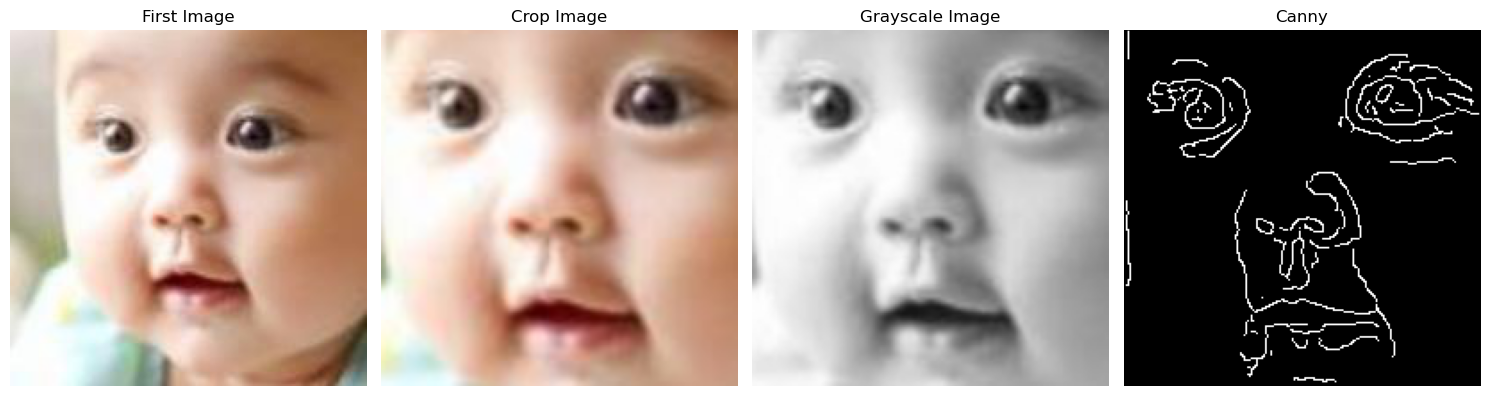

6 Features pertama:  [0.0256, 0.15793872229443925, 16, 0.0384, 0.19215993338883108, 24]
Jumlah Fitur Muka: 192
Fitur Muka:
[2.5599999e-02 1.5793872e-01 1.6000000e+01 3.8400002e-02 1.9215994e-01
 2.4000000e+01 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 4.4799998e-02 2.0686460e-01 2.8000000e+01 7.3600002e-02 2.6111883e-01
 4.6000000e+01 8.0000004e-03 8.9084230e-02 5.0000000e+00 7.5199999e-02
 2.6371378e-01 4.7000000e+01 1.7280000e-01 3.7807429e-01 1.0800000e+02
 1.0080000e-01 3.0106372e-01 6.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 2.0800000e-02 1.4271426e-01 1.3000000e+01 1.7440000e-01
 3.7945309e-01 1.0900000e+02 1.2320000e-01 3.2866663e-01 7.7000000e+01
 1.2960000e-01 3.3586282e-01 8.1000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.1520000e-01 3.1926316e-01 7.2000000e+01 1.0560000e-01
 3.0732498e-01 6.6000000e+01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.1200000e-02 1.0523573e

In [60]:
image_path = 'dataset/final_dataset/test/001_1124_0.png'

feature = extract_features_from_image(image_path)
print("Jumlah Fitur Muka:", len(feature))
print("Fitur Muka:")
print(feature)

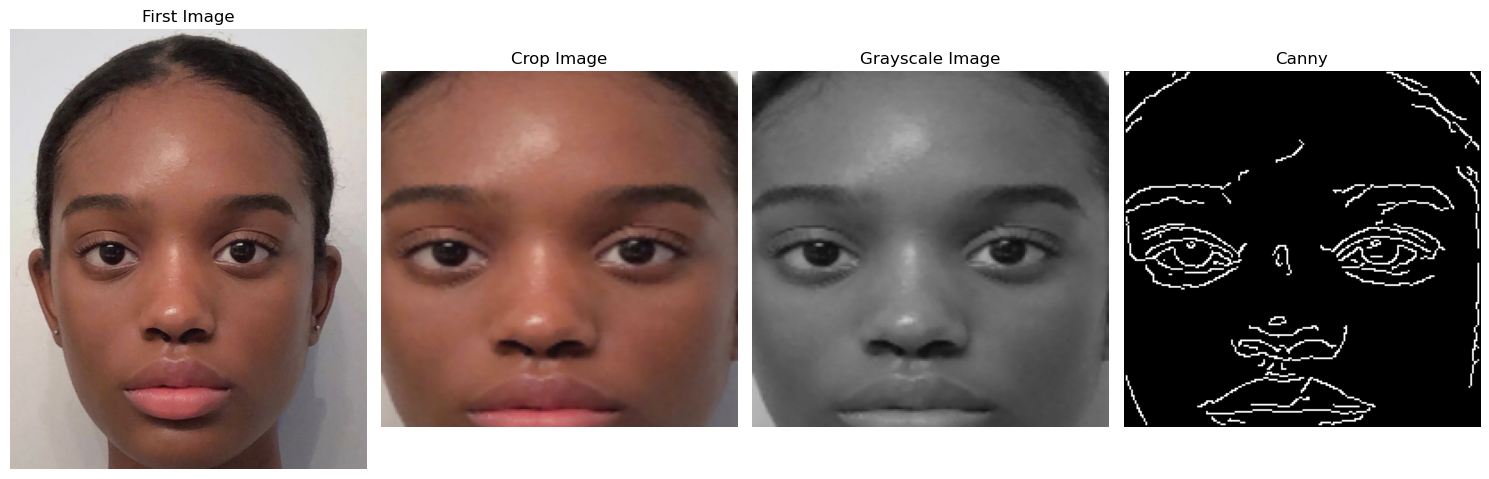

6 Features pertama:  [0.0608, 0.23896309338473168, 38, 0.032, 0.17600000000000002, 20]
Jumlah Fitur Muka: 192
Fitur Muka:
[6.0800001e-02 2.3896310e-01 3.8000000e+01 3.2000002e-02 1.7600000e-01
 2.0000000e+01 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 4.8000002e-03 6.9115557e-02 3.0000000e+00 1.1520000e-01 3.1926316e-01
 7.2000000e+01 4.6399999e-02 2.1034980e-01 2.9000000e+01 3.3599999e-02
 1.8019722e-01 2.1000000e+01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.0400001e-02 1.7168529e-01
 1.9000000e+01 1.6000000e-03 3.9967988e-02 1.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 8.9599997e-02 2.8560784e-01 5.6000000e+01 6.8800002e-02 2.5311372e-01
 4.3000000e+01 7.5199999e-02 2.6371378e-01 4.7000000e+01 4.6399999e-02
 2.1034980e-01 2.9000000e+01 8.0000004e-03 8.9084230e-02 5.0000000e+00
 1.6000001e-02 1.2547509e-

In [61]:
image_path = 'cekombak.jpg'

feature = extract_features_from_image(image_path)
print("Jumlah Fitur Muka:", len(feature))
print("Fitur Muka:")
print(feature)